# Import libraries

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np 
from ipykernel import kernelapp as app
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import optuna
import sklearn
from sklearn import datasets
from sklearn.svm import SVR
import optuna 
import shap
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import os
from new_plot import *
set_things()
set_font()


/Users/sayamsingla/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/sayamsingla/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/sayamsingla/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/sayamsingla/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/Users/sayamsingla/anaconda3/lib/python3.7/_collections_ab

# Reading database

In [2]:
prop ='BulkModulus'
propfile =prop +'.csv'
propcolumnname = 'BulkModulus'
df = pd.read_csv(propfile)
a=df

# Renaming Labels 

In [3]:
old_col = df.columns.tolist()
new_col= {}
for c in old_col:
    new_col[c] = c + str(" [" + str(np.round(a[c].min(),2))+','+str(np.round(a[c].max(),2)) + "]")
df = df.rename(columns= new_col)

# Splitting dataset

In [4]:
data = df.values

X_features = data[:,0:-1]
Y_properties = data[:,-1]

sa = df.columns.values.tolist()
sa = list(sa[:-1])
a10 = sa

X_tr,X_shap,Y_tr,Y_shap = train_test_split(X_features,Y_properties,test_size=0.8, random_state=42)
X_train,X_test,Y_train,Y_test = train_test_split(X_features,Y_properties,test_size=0.2, random_state=33)


kfold = KFold(n_splits=4, shuffle=True,random_state=42)

# Loading Params from trianed Model

In [9]:
file = 'chalco_results2/'+ prop + '/'  + prop +'_XGB2.pickle' 
params  = None
if os.path.isfile(file):
    print(prop)
    with open(file,'rb') as f:
        df2 = pickle.load(f)
    params = df2[3]

In [11]:
if params['booster'] == 'dart':
    s = {'booster':'gbtree'}
    params.update(s)

TypeError: 'NoneType' object is not subscriptable

# Training 

In [172]:
modelxg =  XGBRegressor(**params) 
modelxg.fit(X_train,Y_train)
scores2 = r2_score(modelxg.predict(X_train),Y_train)

0.9999949750844096

# SHAP Values

In [174]:
explainer = shap.TreeExplainer(modelxg)
shap_values = explainer.shap_values(X_shap)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [175]:
import pickle
pickle.dump(shap_values, open(prop+'_shapvalue.pkl','wb'))
#pickle.dump(descending_order, open(prop+'_order.pkl','wb'))

# SHAP summary plot: bar

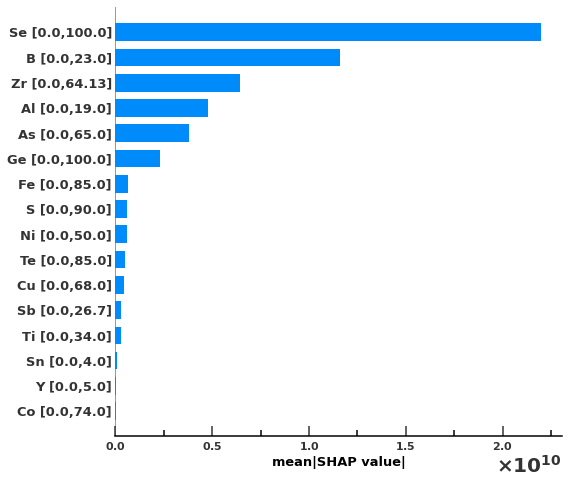

In [176]:
from new_plot import *
shap.initjs()
fig,ax = plt.subplots(figsize=(6,6))
shap.summary_plot(shap_values, X_shap,feature_names=a10,plot_type='bar',show=False)
plt.xlabel('mean|SHAP value|')#+propcolumnname)
#plt.savefig(prop+'bar_plot.png',dpi=1200,bbox_inches='tight')
plt.show()

# SHAP summary plot: violin¶

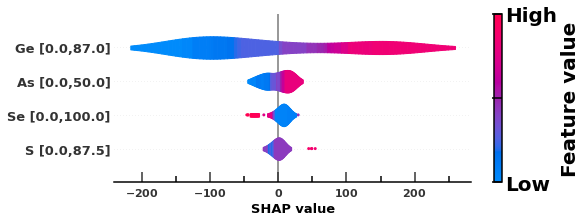

In [143]:
fig,ax = plt.subplots(figsize=(6,6))

shap.summary_plot(shap_values, X_shap ,feature_names= a10,plot_type='violin',show=False,
                 color_bar=False)
plt.xlabel('SHAP value')#+propcolumnname)
cbar = plt.colorbar()
cbar.set_label('Feature value')
cbar.minorticks_off()
#cbar.ax.set_axis_off()
midpoint_cbar = (cbar.vmax + cbar.vmin)/2
cbar.set_ticks([cbar.vmax,midpoint_cbar,cbar.vmin])#,labels=['High','Low'])
cbar.set_ticklabels(['High','','Low'])
plt.savefig(prop+'final_violin_plot.png',dpi=1200,bbox_inches='tight')
plt.show()

# SHAP riverflow plot

In [144]:
df_sv = pd.DataFrame(data = shap_values, columns=a10) 

#converting the column names into descending order of their mean abs sv
descending_order = list(df_sv.abs().mean(axis=0).sort_values(ascending=False).index)

#for river plot
river_sv = df_sv[descending_order[::-1]]
expected_value = explainer.expected_value

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


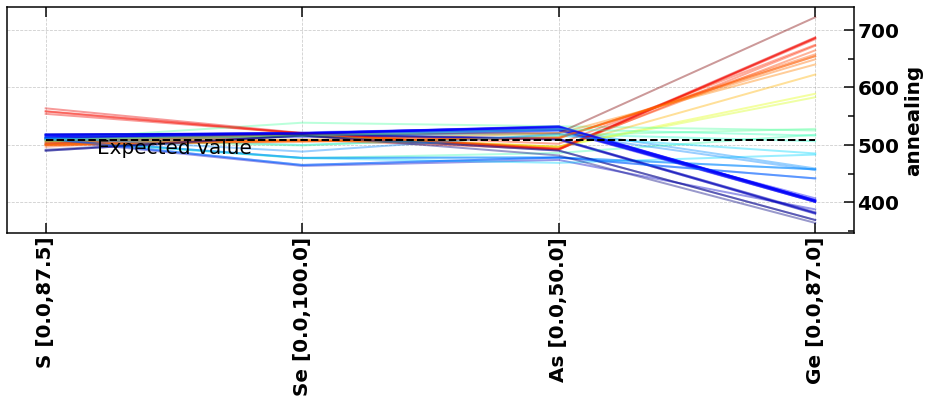

In [147]:
import matplotlib

fig,ax = plt.subplots(figsize=(13,6))

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)
ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=np.min(river_sv.values[:,-1]), vmax=np.max(river_sv.values[:,-1]))
for i in range(len(river_sv)):
    plt.plot(river_sv.values[i].T+expected_value, alpha=0.4, c=cmap(norm(river_sv.values[i,-1])))
plt.plot([0,len(descending_order)-1],[expected_value,expected_value],'k--',linewidth=2.0)

plt.xticks(range(len(descending_order)), labels=list(descending_order[::-1]), size=20, rotation=90)
plt.tight_layout()
plt.text(0.2, expected_value+0.5, r'Expected value'%(expected_value), fontsize=20, fontweight='normal',va='top', ha='left')
plt.grid('on', color="gray", ls="--", which="major", alpha=0.4)
plt.ylabel(propcolumnname)
#plt.savefig('BulkModulus_riverflow.png',dpi=1200,bbox_inches='tight')
plt.show()
